$\newline$
$\newline$
$\newline$


$${\large{\color{black}{\bf{\text{Implementation of Systematic Feedforward Coder for Convolutional Code (2, 1, 3) and Decoder}}}}}$$

$${\large{\color{black}{\text{Based on }}\color{blue}{\underline{\text{Hard Decision Viterbi Algorithm (HDVA)}}}}}$$
$\newline$
$\newline$
$\newline$

In [1]:
import numpy as np
import networkx as nx
from time import time
import itertools as it
from termcolor import colored
import matplotlib.pyplot as plt
from sk_dsp_comm import fec_conv as fec

$\newline$
$\newline$


#### ${\large{\bf{}\;\;\color{purple}{\bf{{\text{Implementation of }\underline{\text{Systematic Feedforward Encoder}}}:}}}}$




$\newline$
$\newline$

$\newline$
$\newline$


> <span style='color: red'><b><font size=2>$\color{red}{\bf{\text{Note: }}}$</font></b></span>


$\newline$
$\newline$
- - - $\color{black}{g^{(0)}\;=\;(1,\;0,\;0,\;0)\;,\;g^{(1)}\;=\;(1,\;1,\;0,\;1)}$
   

$\newline$
$\newline$


- - - $\color{black}{\text{For (2, 1, 3) systematic feedforward encoder we have:}}$
 
$\newline$
$\newline$

- - - - $\bf{G} = \begin{pmatrix}11 & 01 & 00 & 01 & ... &\\00 & 11 & 01 & 00 & 01 & ... &\\00 & 00 & 11 & 01 & 00 & 01 & ... &\\00 & 00 & 00 & 11 & 01 & 00 & 01 & ... &\\ \vdots & & & & \ddots & & & \vdots\end{pmatrix}$



$\newline$
$\newline$
- - - $\text{We assume that }\bf{{u}}\text{ sequence has finite length h, then we will have:}$
   

$\newline$
$\newline$
$\newline$
$\newline$
$\newline$
$\newline$
- - - - $\color{black}{{\bf{v}}_{\;1\;\times\;{2(h + m)}}\; = {\bf{u}}_{\;1\;\times\;{h}}\; \times \; {\bf{G}}_{\;1\;\times\;{2(h + m)}}}$
     


      
$\newline$
$\newline$
$\newline$
$\newline$

$\newline$
- [x] ${{\bf{}\;\;\color{green}{\bf{\text{Lookup Table that includes first row of G matrix:}}}}}$

  
$\newline$

In [14]:
LOOKUP_TABLE_Conv = {(2, 1, 3): {'g0': np.array([1, 0, 0, 0], dtype=np.int64), 'g1': np.array([1, 1, 0, 1], dtype=np.int64)}, \
                    (3, 1, 2): {'g0': np.array([1, 1, 0]), 'g1': np.array([1, 0, 1]), 'g2': np.array([1, 1, 1])}}

$\newline$
- [x] ${{\bf{}\;\;\color{green}{\bf{\text{G Generation:}}}}}$

  
$\newline$

In [3]:
def First_Row_Generator(g_dict: dict) -> np.ndarray:
    num_memory_bits = len(g_dict[list(g_dict.keys())[0]]) - 1
    g_list = []
    for i in range(num_memory_bits + 1):
        for key in g_dict.keys():
            g = g_dict[key]
            g_list.append(g[i])
    g_ndarray = np.array(g_list, dtype=np.int64)
    return g_ndarray

In [4]:
def G_Generator(conv_tuple: tuple, u_length: int) -> np.ndarray:
    h, num_output_bits, m= u_length, conv_tuple[0], conv_tuple[2]
    G = np.zeros((h, num_output_bits*(h + m)), dtype=np.int64)
    g_dict = LOOKUP_TABLE_Conv[conv_tuple]
    g = First_Row_Generator(g_dict)
    count = 0
    for i in range(len(G)):
        G[i][count: len(g) + count] = g
        count += num_output_bits
    return G

$\newline$
- - $\small{\bf{}\;\;\color{olive}{\bf{\text{Test:}}}}$
 

$\newline$

In [5]:
h = 5
G = G_Generator(conv_tuple=(2, 1, 3), u_length=h)
print(f'\n{colored(f"For Systematic Feedforward Convolutional Code (2, 1, 3) when we have h = {h}, G Matrix will be:", "blue", attrs=["bold"])}\n\n{colored("G =", "black", attrs=["bold"])} \n{G}\n')


For Systematic Feedforward Convolutional Code (2, 1, 3) when we have h = 5, G Matrix will be:

G = 
[[1 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 1 1 0 1 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1]]



$\newline$
- [x] ${{\bf{}\;\;\color{green}{\bf{\text{u Sequence Generation:}}}}}$


$\newline$

In [6]:
def u_seq_Generator(h: int) -> np.ndarray:
    np.random.seed(0)
    u = np.random.randint(low=0, high=2, size=(1, h), dtype=np.int64)
    return u

$\newline$
- - $\small{\bf{}\;\;\color{olive}{\bf{\text{Test:}}}}$
 

$\newline$

In [7]:
h = 5
u_seq = u_seq_Generator(h=h)
print(f'\n{colored(f"For h={h}, u sequence that includes our messages will be: ", "blue", attrs=["bold"])}\n\n{colored("u = ", "black", attrs=["bold"])}{u_seq[0]}\n')


For h=5, u sequence that includes our messages will be: 

u = [0 1 1 0 1]



$\newline$
- [x] ${{\bf{}\;\;\color{green}{\bf{\text{v Sequence Generation}}}}}$


$\newline$

In [8]:
def Coder(conv_tuple: tuple, u_seq) -> np.ndarray:
    h = u_seq.shape[1]
    G = G_Generator(conv_tuple=conv_tuple, u_length=h)
    v_seq = (u_seq @ G) % 2
    return v_seq

$\newline$
- - $\small{\bf{}\;\;\color{olive}{\bf{\text{Test:}}}}$
 

$\newline$

In [9]:
conv_tuple = (2, 1, 3)
v_seq = Coder(conv_tuple=(2, 1, 3), u_seq=u_seq)
print(f'\n{colored(f"For Systematic feedforward convolutional code {conv_tuple} v sequence that includes our codewords will be:", "blue", attrs=["bold"])}\
\n\n{colored("u = ", "black", attrs=["bold"])}{u_seq[0]}\n\n{colored("v = ", "black", attrs=["bold"])}{v_seq[0]}\n')


For Systematic feedforward convolutional code (2, 1, 3) v sequence that includes our codewords will be:

u = [0 1 1 0 1]

v = [0 0 1 1 1 0 0 1 1 0 0 0 0 0 0 1]



$\newline$
$\newline$


#### ${\large{\bf{}\;\;\color{purple}{\bf{{\text{Implementation of }\underline{\text{Viterbi Algorithm }}\text{ as an Optimum Decoder:}}}}}}$




$\newline$
$\newline$

$\newline$
- [x] ${{\bf{}\;\;\color{green}{\bf{\text{State Diagram Generation as a Dictionary Data Structure}}}}}$


$\newline$

In [10]:
def Next_State(current_state: int, num_memory_bits: int, input_bits: str) -> int:
    k = len(input_bits)
    current_state_binary = bin(current_state)[2:].zfill(num_memory_bits)
    next_state = current_state << k
    next_state_binary = bin(next_state)[2:].zfill(num_memory_bits)
    next_state_binary = next_state_binary[-num_memory_bits: -k]
    next_state_binary = next_state_binary + input_bits[-1::-1]
    next_state = int(next_state_binary, 2)
    return next_state

In [11]:
def Output_Generator(current_state: int, input_bit: str, num_output_bits: int, g_dict: dict) -> str:
    m = len(g_dict['g0']) - 1
    current_state_binary = bin(current_state)[2:].zfill(m)
    output_bits_str = ''
    for i in range(num_output_bits):
        g = g_dict['g' + str(i)]
        g0 = g[0]
        g_rem = g[1:]
        output = (int(input_bit, 2) * g0) % 2
        for j in range(m):
            output += (int(current_state_binary[m - j -1], 2) * g_rem[j]) % 2
            output %= 2
        output_bits_str += str(output)
    return output_bits_str[::-1]

In [12]:
def State_Diagram_Generator(conv_tuple: tuple=(2, 1, 3)) -> dict:
    num_output_bits, num_input_bits, num_memory_bits = conv_tuple
    g_dict = LOOKUP_TABLE_Conv[conv_tuple]

    num_states = 2 ** num_memory_bits
    states_dict = {}
    for current_state in range(num_states):
        
        transitions = {}
        for input_bits in range(2 ** num_input_bits):
            input_bits_binary_str = bin(input_bits)[2:].zfill(num_input_bits)
            output_bits_binary_str = Output_Generator(current_state=current_state, input_bit=input_bits_binary_str, num_output_bits=num_output_bits, g_dict=g_dict)
            next_state = Next_State(current_state=current_state, num_memory_bits=num_memory_bits, input_bits=input_bits_binary_str)
            transitions[input_bits] = {'input_bits': input_bits_binary_str, 'output_bits': output_bits_binary_str, 'next_state': next_state}

        states_dict[current_state] = transitions
    return states_dict

$\newline$
- - $\small{\bf{}\;\;\color{olive}{\bf{\text{Test:}}}}$
 

$\newline$

In [15]:
conv_tuple = (3, 1, 2)
state_diagram_dict = State_Diagram_Generator(conv_tuple=conv_tuple)
print(f'\n{colored(f"State Diagram as a Dictionary Data Structure for Covolutional Code {conv_tuple}:", "blue", attrs=["bold"])}\n\n{state_diagram_dict}\n')


State Diagram as a Dictionary Data Structure for Covolutional Code (3, 1, 2):

{0: {0: {'input_bits': '0', 'output_bits': '000', 'next_state': 0}, 1: {'input_bits': '1', 'output_bits': '111', 'next_state': 1}}, 1: {0: {'input_bits': '0', 'output_bits': '101', 'next_state': 2}, 1: {'input_bits': '1', 'output_bits': '010', 'next_state': 3}}, 2: {0: {'input_bits': '0', 'output_bits': '110', 'next_state': 0}, 1: {'input_bits': '1', 'output_bits': '001', 'next_state': 1}}, 3: {0: {'input_bits': '0', 'output_bits': '011', 'next_state': 2}, 1: {'input_bits': '1', 'output_bits': '100', 'next_state': 3}}}



$\newline$
- [x] ${{\bf{}\;\;\color{green}{\bf{\text{State Diagram Showing}}}}}$


$\newline$

In [16]:
def Draw_State_Diagram(conv_tuple: tuple=(2, 1, 3)):
    state_diagram_dict = State_Diagram_Generator(conv_tuple)
    G = nx.DiGraph()

    for state, transitions in state_diagram_dict.items():
        for input_bit, next_state in transitions.items():
            input_bits = next_state['input_bits']
            output_bits = next_state['output_bits']
            next_state_id = next_state['next_state']
            label = f'{input_bits}/{output_bits}'
            G.add_edge(state, next_state_id, label=label)

    pos = nx.circular_layout(G)
    plt.figure(figsize=(10, 5))
    nx.draw(G, pos, with_labels=True, node_size=1000, node_color='lightblue', font_size=12, font_weight='bold')
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='black', font_size=10)
    plt.title(f'\nState Diagram for Convolutional Code {conv_tuple}\n', fontsize=10, fontweight='bold')
    plt.show()

$\newline$
- - $\small{\bf{}\;\;\color{olive}{\bf{\text{Test:}}}}$
 

$\newline$

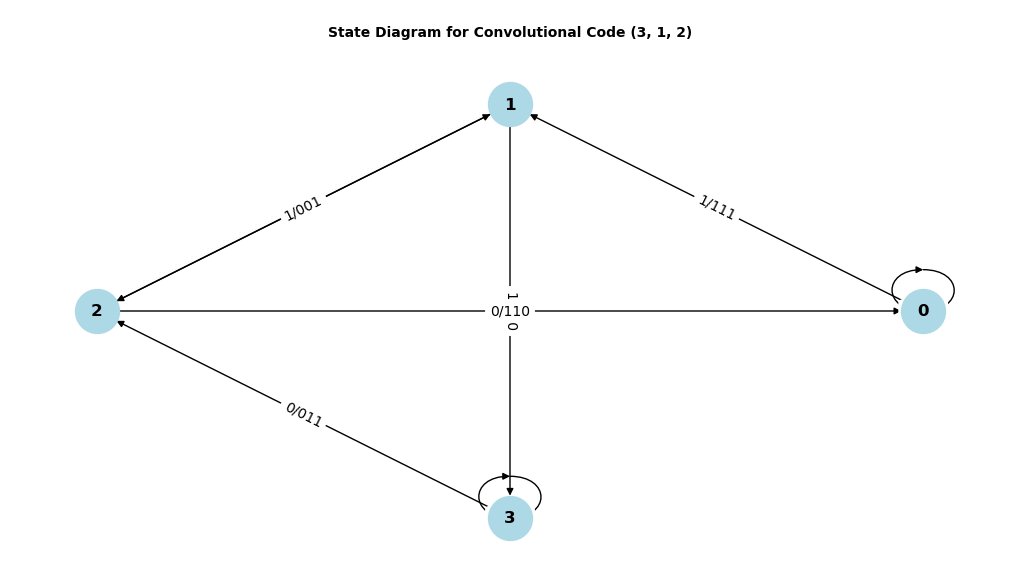

In [17]:
conv_tuple = (3, 1, 2)
Draw_State_Diagram(conv_tuple=conv_tuple)

$\newline$
- [x] ${{\bf{}\;\;\color{green}{\bf{\text{R (received sequence) Generation:}}}}}$


$\newline$

In [18]:
def R_Generator(v_seq: np.ndarray) -> np.ndarray:
    l = v_seq.shape[1]
    e = np.zeros(shape=(1, l), dtype=np.int64)
    e[0, 0] = 1
    R = (v_seq + e) % 2
    return R

$\newline$
- - $\small{\bf{}\;\;\color{olive}{\bf{\text{Test:}}}}$
 

$\newline$

In [81]:
R_seq = R_Generator(v_seq=v_seq)
print(f'\n{colored("When we have error pattern that has 1 in the first element of itself: ", "blue", attrs=["bold"])}\n\n{colored("u = ", "black", attrs=["bold"])}{u_seq[0]}\n\n\
{colored("v = ", "black", attrs=["bold"])}{v_seq[0]}\n\n{colored("R = ", "black", attrs=["bold"])}{R_seq[0]}\n')


When we have error pattern that has 1 in the first element of itself: 

u = [0 1 1 0 1]

v = [0 0 1 1 1 0 0 1 1 0 0 0 0 0 0 1]

R = [1 0 1 1 1 0 0 1 1 0 0 0 0 0 0 1]



$\newline$
- [x] ${{\bf{}\;\;\color{green}{\bf{\text{G Preparation:}}}}}$


$\newline$

In [20]:
def Array_to_String(array: np.ndarray) -> str:
    out_str = ''
    for i in array:
        out_str += str(i)

    return out_str

$\newline$
- - $\small{\bf{}\;\;\color{olive}{\bf{\text{Test:}}}}$
 

$\newline$

In [76]:
conv_tuple = (2, 1, 3)
g_dict = LOOKUP_TABLE_Conv[conv_tuple]
g0, g1 = g_dict['g0'], g_dict['g1']
g0_str, g1_str = Array_to_String(g0), Array_to_String(g1)
print(f'\n{colored("G Matrix Preparation:", "blue", attrs=["bold"])}\n\n\n{colored("g0 = ", "black", attrs=["bold"])}{g0}\n\n{colored("g0_str = ", "black", attrs=["bold"])}{g0_str}\n\
\n\n{colored("g1 = ", "black", attrs=["bold"])}{g1}\n\n{colored("g1_str = ", "black", attrs=["bold"])}{g1_str}\n')


G Matrix Preparation:


g0 = [1 0 0 0]

g0_str = 1000


g1 = [1 1 0 1]

g1_str = 1101



$\newline$
- [ ] ${{\bf{}\;\;\color{green}{\bf{\text{HDVA-Based Decoder:}}}}}$


$\newline$

In [77]:
def HDVA(R_seq: np.ndarray, conv_tuple) -> np.ndarray:
    m = conv_tuple[2]
    g_dict = LOOKUP_TABLE_Conv[conv_tuple]
    G = []
    for key in g_dict.keys():
        g = g_dict[key]
        g_str = Array_to_String(g)
        G.append(g_str)
    Conv_Coding = fec.FECConv(G=G, Depth=m+1) # Depth = m + 1
    Decoded_seq = Conv_Coding.viterbi_decoder(x=R_seq, metric_type='hard')
    Decoded_seq = Decoded_seq.astype(int)
    return Decoded_seq

$\newline$
- - $\small{\bf{}\;\;\color{olive}{\bf{\text{Test:}}}}$
 

$\newline$

In [78]:
u_hat_seq = HDVA(R_seq=R_seq[0], conv_tuple=(2, 1, 3))
print(f'\n{colored("For estimated sequence we will have:", "blue", attrs=["bold"])}\n\n{colored("u-hat = ", "black", attrs=["bold"])}{u_hat_seq}\n\n{colored("u = ", "black", attrs=["bold"])}{u_seq[0]}\n')
print(f'\n{colored("When we have:", "blue", attrs=["bold"])}\n\n{colored("R = ", "black", attrs=["bold"])}{R_seq[0]}\n\n{colored("v = ", "black", attrs=["bold"])}{v_seq[0]}\n')


For estimated sequence we will have:

u-hat = [1 1 1 0 1]

u = [0 1 1 0 1]


When we have:

R = [1 0 1 1 1 0 0 1 1 0 0 0 0 0 0 1]

v = [0 0 1 1 1 0 0 1 1 0 0 0 0 0 0 1]



$\newline$
$\newline$
$\newline$


$\large{\bf{\;\;\color{purple}{\bf{{\text{Conclusion:}}}}}}$


$\newline$
$\newline$
- ${{\color{black}{\text{As we saw for the error pattern that has 1 in the first element of itself, the Viterbi Algorithm}}}}$
  ${\color{black}{\text{ does decoding as correctly except in the first element of the message sequence.}}}$


$\newline$
$\newline$
$\newline$

$\newline$
$\newline$

#### <a name=''>${\large{\bf{}\;\;\color{blue}{\bf{{\text{References:}}}}}}$</a>


$\newline$
$\newline$

- <a name=''>[${{\bf{}\;\;\color{blue}{\bf{\underline{\text{Viterbi Decoder}}}}}}$](https://scikit-dsp-comm.readthedocs.io/en/latest/fec_conv.html#sk_dsp_comm.fec_conv.FECConv.viterbi_decoder)</a>


$\newline$
$\newline$


- <a name=''>[${{\bf{}\;\;\color{blue}{\bf{\underline{\text{Installation}}}}}}$](https://pypi.org/project/scikit-dsp-comm/)</a>


$\newline$
$\newline$